In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Suppress TensorFlow logging (except for errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Additional TensorFlow logging suppression
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

2024-03-13 16:55:47.984541: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 16:55:48.034866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 16:55:48.034907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 16:55:48.036550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 16:55:48.044789: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 16:55:48.045529: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
from history import history
from girth import girth
from girth_goal import girth_goal

In [3]:
# Filter and prepare the data
df = pd.DataFrame(history).copy()  # Make sure 'history' is already loaded with your data
user_df = df[df['b_user_id'] == 3000740292287583700]
user_df['created_at'] = pd.to_datetime(user_df['created_at'].astype(str), errors='coerce')
user_df.sort_values('created_at', inplace=True)
user_df.reset_index(drop=True, inplace=True)
user_df['date_ordinal'] = user_df['created_at'].map(datetime.toordinal)

# Convert 'created_at' to timezone-naive datetime objects to avoid timezone mismatch issues
user_df['created_at'] = user_df['created_at'].dt.tz_localize(None)

# Feature and target selection
X = user_df[['date_ordinal']]
y = user_df['weight']

/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


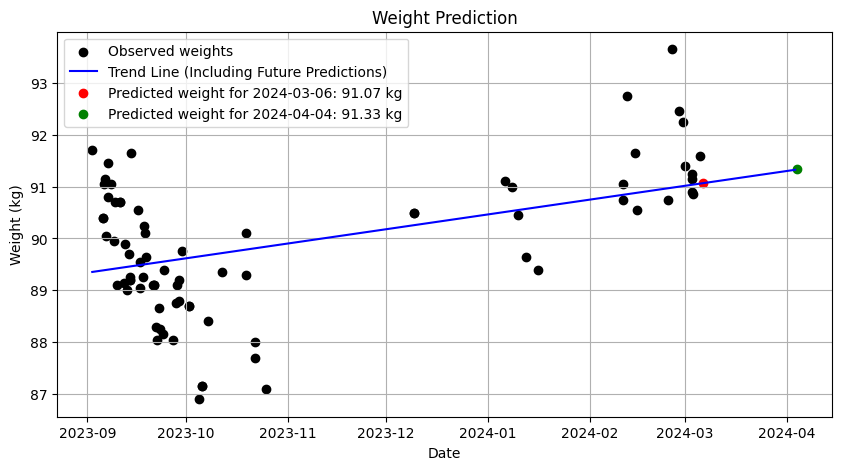

Predicted weight for 2024-03-06: 91.07 kg
Predicted weight for 2024-04-04: 91.33 kg


/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# To continue the trend line, generate a range of dates from the earliest in your dataset to one month into the future
date_min = user_df['created_at'].min()
date_max = user_df['created_at'].max() + pd.DateOffset(days=30)  # 30 days added to the last date

# Create a DataFrame with a continuous range of dates
date_range = pd.date_range(start=date_min, end=date_max)
date_ordinal_range = np.array([d.toordinal() for d in date_range]).reshape(-1, 1)

# Predict weights for this entire date range
predicted_weights_range = model.predict(date_ordinal_range)

# Predict the weight for the next day
next_day_date = user_df['created_at'].max() + pd.DateOffset(days=1)
next_day_ordinal = next_day_date.toordinal()

# Predict the weight for the next day
predicted_weight_next_day = model.predict([[next_day_ordinal]])

# Predict the weight for the next month
next_month = user_df['date_ordinal'].max() + 30
next_month_ordinal = next_month

# Plot the results
plt.figure(figsize=(10, 5))

# Plot the observed weights
plt.scatter(user_df['created_at'], user_df['weight'], color='black', label='Observed weights')

# Plot the trend line including predictions for the next day and next month
plt.plot(date_range, predicted_weights_range, color='blue', label='Trend Line (Including Future Predictions)')

# Highlight the prediction for the next day
plt.scatter(next_day_date, predicted_weight_next_day, color='red', label=f'Predicted weight for {next_day_date.strftime("%Y-%m-%d")}: {predicted_weight_next_day[0]:.2f} kg')

# Highlight the prediction for the next month (30 days later)
next_month_date = datetime.fromordinal(next_month)
plt.scatter(next_month_date, model.predict([[next_month]])[0], color='green', label=f'Predicted weight for {next_month_date.strftime("%Y-%m-%d")}: {model.predict([[next_month]])[0]:.2f} kg')

plt.title('Weight Prediction')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.grid(True)
plt.legend()

plt.show()

# Print out the metrics for the next day
print(f"Predicted weight for {next_day_date.strftime('%Y-%m-%d')}: {predicted_weight_next_day[0]:.2f} kg")

# Print out the metrics for the next month
print(f"Predicted weight for {next_month_date.strftime('%Y-%m-%d')}: {model.predict([[next_month]])[0]:.2f} kg")

/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


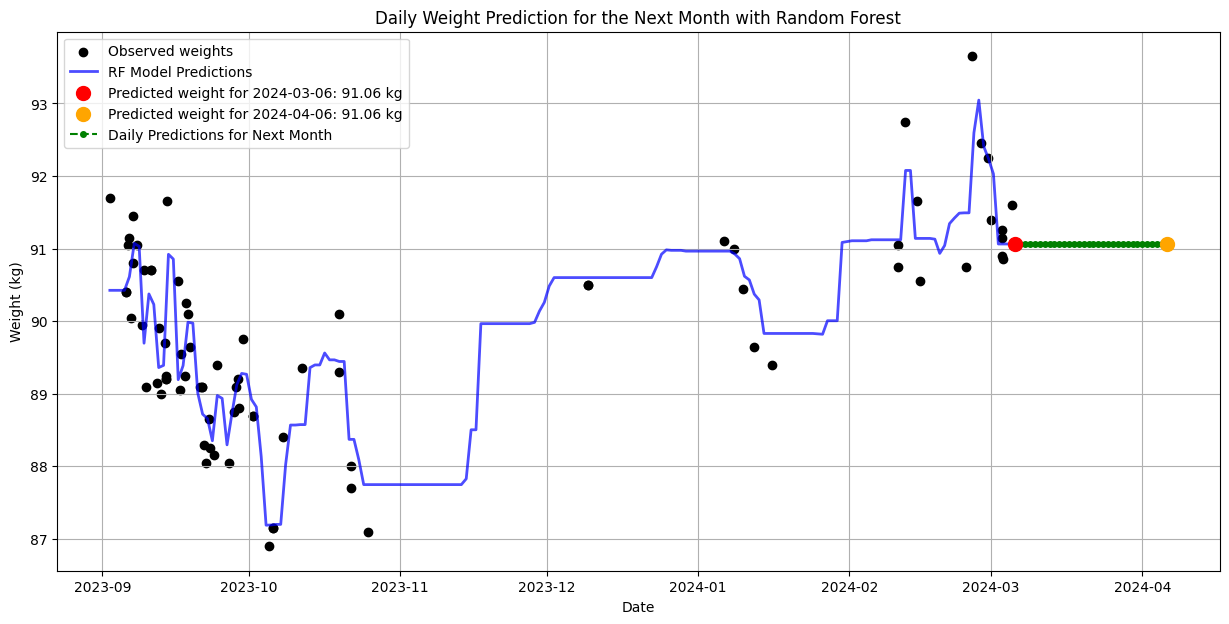

Predicted weight for 2024-03-06: 91.06 kg
Predicted weight for 2024-04-06: 91.06 kg


In [5]:
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = polynomial_features.fit_transform(X)

# Split dataset with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_poly, y_train)

# Predictions for the test set
y_pred_rf = rf_model.predict(X_test_poly)

# Prediction setup for the next day
next_day = max(user_df['date_ordinal']) + 1
next_day_poly = polynomial_features.transform([[next_day]])
predicted_weight_next_day_rf = rf_model.predict(next_day_poly)
next_day_date = datetime.fromordinal(next_day)

# Prediction setup for one month later
one_month_later_date = next_day_date + relativedelta(months=+1)
one_month_later_ordinal = np.array([[one_month_later_date.toordinal()]])
one_month_later_poly = polynomial_features.transform(one_month_later_ordinal)
predicted_weight_one_month_later = rf_model.predict(one_month_later_poly)

# Generate a date range for plotting predictions, including the next month
date_range = pd.date_range(start=user_df['created_at'].min(), end=one_month_later_date, freq='D')
date_ordinal_range = np.array([d.toordinal() for d in date_range]).reshape(-1, 1)
date_range_poly = polynomial_features.transform(date_ordinal_range)

# Predict weights for the entire date range
predicted_weights_range = rf_model.predict(date_range_poly)

# Generate a sequence of daily dates for the next month
daily_dates_next_month = pd.date_range(start=next_day_date + pd.Timedelta(days=1), end=one_month_later_date)

# Convert these dates to ordinal for polynomial transformation
daily_dates_next_month_ordinals = np.array([date.toordinal() for date in daily_dates_next_month]).reshape(-1, 1)

# Transform the ordinal dates through the polynomial features process
daily_dates_next_month_poly = polynomial_features.transform(daily_dates_next_month_ordinals)

# Predict weights for each day in the next month
predicted_weights_daily_next_month = rf_model.predict(daily_dates_next_month_poly)

# Visualization
plt.figure(figsize=(15, 7))
plt.scatter(user_df['created_at'], user_df['weight'], color='black', label='Observed weights')
plt.plot(date_range, predicted_weights_range, color='blue', linewidth=2, label='RF Model Predictions', alpha=0.7)
plt.scatter(next_day_date, predicted_weight_next_day_rf, color='red', s=100, zorder=5, label=f'Predicted weight for {next_day_date.strftime("%Y-%m-%d")}: {predicted_weight_next_day_rf[0]:.2f} kg')
plt.scatter(one_month_later_date, predicted_weight_one_month_later, color='orange', s=100, zorder=5, label=f'Predicted weight for {one_month_later_date.strftime("%Y-%m-%d")}: {predicted_weight_one_month_later[0]:.2f} kg')

# Plotting daily predictions for the next month
plt.plot(daily_dates_next_month, predicted_weights_daily_next_month, color='green', marker='o', linestyle='--', markersize=4, label='Daily Predictions for Next Month')

plt.title('Daily Weight Prediction for the Next Month with Random Forest')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.show()

# Print predicted weights for the next day and one month later
print(f"Predicted weight for {next_day_date.strftime('%Y-%m-%d')}: {predicted_weight_next_day_rf[0]:.2f} kg")
print(f"Predicted weight for {one_month_later_date.strftime('%Y-%m-%d')}: {predicted_weight_one_month_later[0]:.2f} kg")

Epoch 34: early stopping


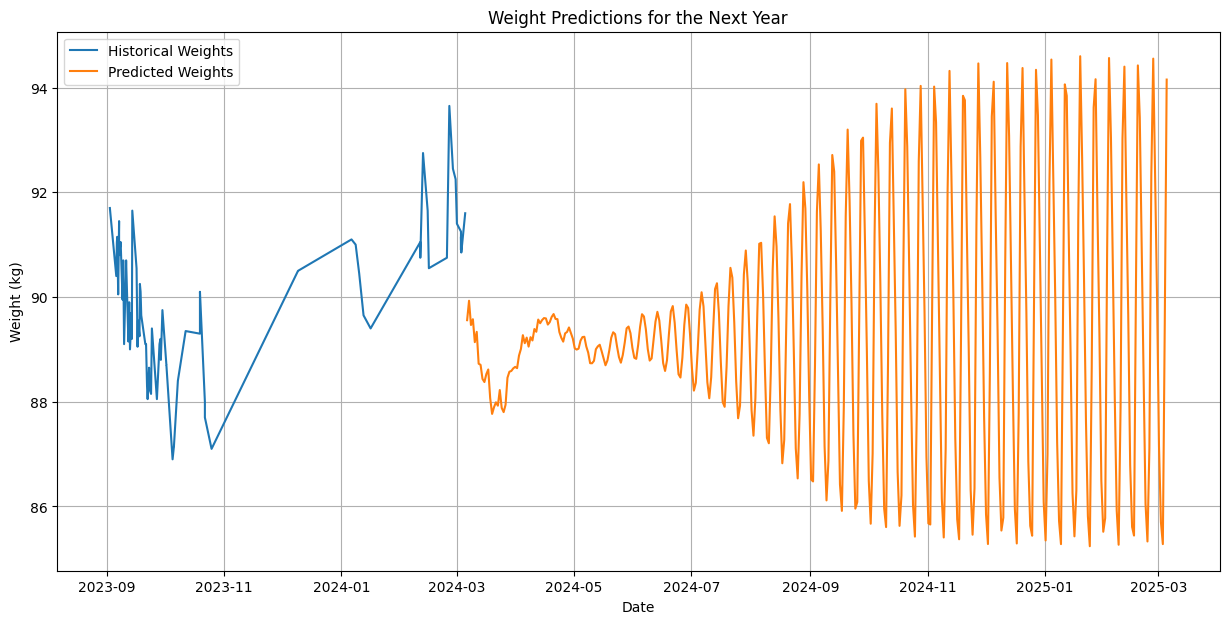

In [16]:
# Normalize the weight data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_weights = scaler.fit_transform(user_df[['weight']])

# Create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, Y = create_dataset(scaled_weights, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split into train and test sets
train_size = int(len(X) * 0.67)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=0, callbacks=[early_stop])

# Make predictions
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

# Prepare the initial state from the last `look_back` known weights
last_weights = scaled_weights[-look_back:]

# Predict future weights one day at a time using the model
future_predictions = []
for _ in range(365):
    # Reshape the last weights for prediction
    last_weights_reshaped = np.reshape(last_weights, (1, 1, look_back))

    # Predict the next day's weight
    next_weight_pred = model.predict(last_weights_reshaped, verbose=0)

    # Append the predicted weight (still scaled)
    future_predictions.append(next_weight_pred[0, 0])

    # Update the last weights using a rolling window
    last_weights = np.append(last_weights[1:], next_weight_pred)

# Invert scaling for future predictions to original weight scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot results
last_date = user_df['created_at'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 366)]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(user_df['created_at'], user_df['weight'], label='Historical Weights')
plt.plot(future_dates, future_predictions, label='Predicted Weights')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Weight Predictions for the Next Year')
plt.legend()
plt.grid(True)
plt.show()


Reloading Tuner from my_dir/lstm_optimization/tuner0.json


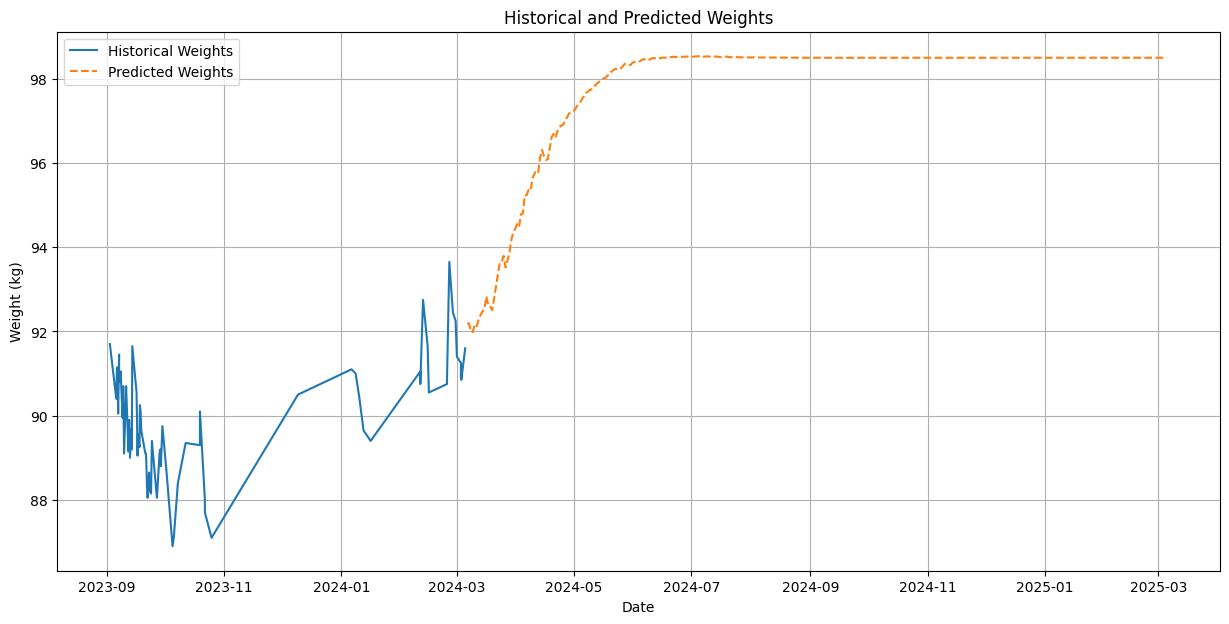

In [18]:
# Normalize the weight data
scaler = MinMaxScaler(feature_range=(0, 1))
user_df['scaled_weight'] = scaler.fit_transform(user_df[['weight']])

# Create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(user_df['scaled_weight'].values, look_back)
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split into train and test sets
train_size = int(len(X) * 0.67)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Ensure Y_train and Y_test are 1D arrays
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

# Define model creation function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=4, max_value=64, step=4), input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model

# Initialize tuner
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=3, directory='my_dir', project_name='lstm_optimization')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(X_train, Y_train, epochs=100, batch_size=2, validation_data=(X_test, Y_test), callbacks=[early_stop])

# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters()[0]
model = build_model(best_hps)

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=0, validation_data=(X_test, Y_test), callbacks=[early_stop])

# Predict future weights
last_weights = user_df['scaled_weight'].values[-look_back:].reshape(1, 1, look_back)
future_predictions = model.predict(last_weights, verbose=0)

# Reshape future_predictions if needed and inverse scale
future_predictions = future_predictions.reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Generate future dates and plot results
last_date = user_df['created_at'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=len(future_predictions), freq='D')

last_input = user_df['scaled_weight'].values[-look_back:].reshape((1, 1, look_back))

# Initialize an empty list for future predictions
future_predictions_scaled = []

# Predict future weights for 365 days
for _ in range(365):
    # Predict the next weight
    next_weight_pred = model.predict(last_input, verbose=0)
    future_predictions_scaled.append(next_weight_pred[0, 0])

    # Update the last_input with the predicted value
    last_input = np.roll(last_input, -1)
    last_input[0, 0, -1] = next_weight_pred[0, 0]

# Convert the list of predictions to a NumPy array and inverse transform to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Generate future dates starting the day after the last date in the historical data
future_dates = pd.date_range(start=user_df['created_at'].iloc[-1] + pd.Timedelta(days=1), periods=365)

# Plotting historical data and future predictions
plt.figure(figsize=(15, 7))
plt.plot(user_df['created_at'], user_df['weight'], label='Historical Weights')
plt.plot(future_dates, future_predictions, label='Predicted Weights', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Historical and Predicted Weights')
plt.legend()
plt.grid(True)
plt.show()